In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# 1. Supervised Learning and Kernel Methods

In [34]:
from kmtr.kernel_solvers import VanillaKRR, Nystrom, Falkon

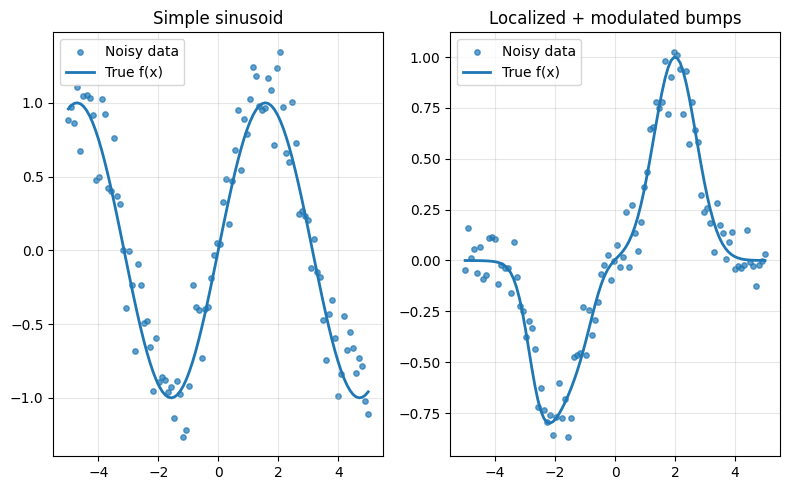

In [35]:
# Toy dataset
n = 100

X = np.linspace(-5, 5, n).reshape(-1, 1)
X_test = np.linspace(-6, 6, 100).reshape(-1, 1)

y_sin_star = np.sin(X).ravel()
y_sin = y_sin_star + 0.2 * np.random.randn(n)

y_2_star = (
    np.exp(-(X - 2)**2)                          # bump near +2
    - 0.8 * np.exp(-(X + 2 + 0.2*np.sin(2*X))**2)  # distorted bump near -2
).ravel()

y_2 = y_2_star + 0.1 * np.random.randn(n)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].scatter(X, y_sin, s=15, alpha=0.7, label="Noisy data")
ax[0].plot(X, y_sin_star, lw=2, label="True f(x)")
ax[0].set_title("Simple sinusoid")
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].scatter(X, y_2, s=15, alpha=0.7, label="Noisy data")
ax[1].plot(X, y_2_star, lw=2, label="True f(x)")
ax[1].set_title("Localized + modulated bumps")
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()


In [36]:
vanilla_krr = VanillaKRR(sigma=0.1, lam=0.1)
vanilla_krr.fit(X,y_sin)
y_pred1 = vanilla_krr.predict(X_test)


vanilla_krr = VanillaKRR(lam=1e-3, sigma=0.7)
vanilla_krr.fit(X,y_2)
y_pred2 = vanilla_krr.predict(X_test)

mse1 = mean_squared_error(y_sin_star, y_pred1)
mse2 = mean_squared_error(y_2_star, y_pred2)

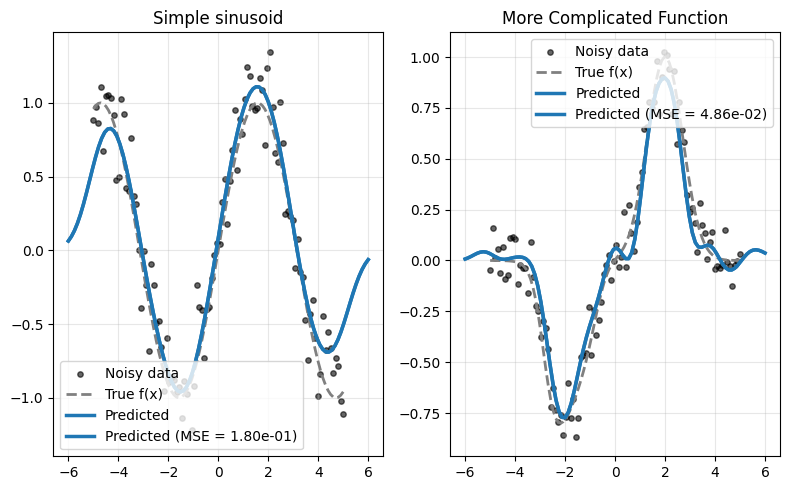

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].scatter(X, y_sin, s=15, alpha=0.6, label="Noisy data", marker="o",color="black")
ax[0].plot(X, y_sin_star, label="True f(x)", linestyle="--", color="grey", linewidth=2)
ax[0].plot(X_test,y_pred1,label="Predicted",color = "#1f77b4", linewidth=2.5)
ax[0].set_title("Simple sinusoid")
ax[0].legend()
ax[0].grid(alpha=0.3)
ax[0].plot(
    X_test,
    y_pred1,
    label=f"Predicted (MSE = {mse1:.2e})",
    linewidth=2.5
)
ax[0].legend()

ax[1].scatter(X, y_2, s=15, alpha=0.6, label="Noisy data", marker="o",color="black")
ax[1].plot(X, y_2_star, lw=2, label="True f(x)",linestyle="--", color="grey")
ax[1].plot(X_test,y_pred2,label="Predicted",color = "#1f77b4", linewidth=2.5)
ax[1].set_title("More Complicated Function")
ax[1].plot(
    X_test,
    y_pred2,
    label=f"Predicted (MSE = {mse2:.2e})",
    linewidth=2.5
)
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/KRR_example.png", dpi=250)


# 2. Nyström Approximation and Reduced Kernel Solvers

In [38]:
n = 1000

X = np.linspace(-5, 5, n).reshape(-1, 1)
X_test = np.linspace(-6, 6, 100).reshape(-1, 1)

y_sin_star = np.sin(X).ravel()
y_sin = y_sin_star + 0.2 * np.random.randn(n)

y_2_star = (
    np.exp(-(X - 2)**2)
    - 0.8 * np.exp(-(X + 2 + 0.2*np.sin(2*X))**2)
).ravel()

y_2 = y_2_star + 0.1 * np.random.randn(n)

# True test targets (for MSE)
y_sin_star_test = np.sin(X_test).ravel()
y_2_star_test = (
    np.exp(-(X_test - 2)**2)
    - 0.8 * np.exp(-(X_test + 2 + 0.2*np.sin(2*X_test))**2)
).ravel()

In [39]:
# ---------- Models ----------
sigma = 1.0
lam   = 1e-2
m     = 50

# Function 1
nysrtom1 = Nystrom(sigma=sigma, lam=lam)
nysrtom1.fit(X, y_sin, m=m)
y_pred_sin_nys = nysrtom1.predict(X_test)

vanilla_krr = VanillaKRR(sigma=sigma, lam=lam)
vanilla_krr.fit(X, y_sin)
y_pred_sin_vanilla = vanilla_krr.predict(X_test)

# Function 2
nysrtom2 = Nystrom(sigma=sigma, lam=lam)
nysrtom2.fit(X, y_2, m=m)
y_pred_2_nys = nysrtom2.predict(X_test)

vanilla_krr = VanillaKRR(sigma=sigma, lam=lam)
vanilla_krr.fit(X, y_2)
y_pred_2_vanilla = vanilla_krr.predict(X_test)
mse_sin_van   = mean_squared_error(y_sin_star_test, y_pred_sin_vanilla)
mse_sin_nys   = mean_squared_error(y_sin_star_test, y_pred_sin_nys)

mse_2_van     = mean_squared_error(y_2_star_test,  y_pred_2_vanilla)
mse_2_nys     = mean_squared_error(y_2_star_test,  y_pred_2_nys)

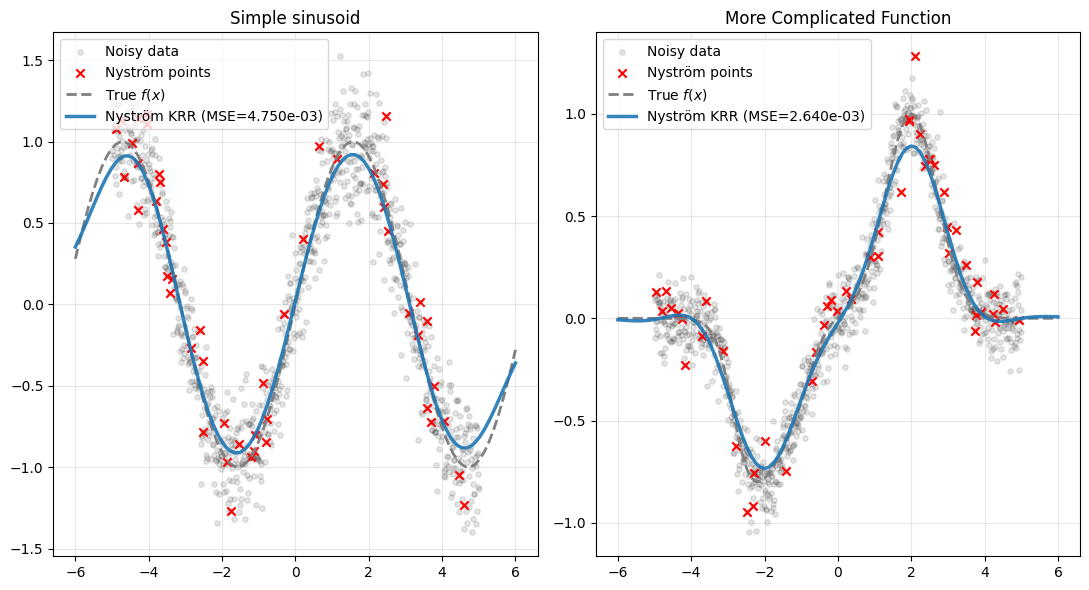

In [40]:
# ---------- Plot ----------
fig, ax = plt.subplots(1, 2, figsize=(11, 6))

# --- Sinusoid ---
ax[0].scatter(X, y_sin, s=15, alpha=0.1, label="Noisy data", marker="o", color="black")

ax[0].scatter(
    nysrtom1.Xm, y_sin[nysrtom1.indices],
    label="Nyström points", marker="x", color="red",
)

# True function
ax[0].plot(
    X_test,
    y_sin_star_test,
    linestyle="--",
    color="grey",
    lw=2,
    label="True $f(x)$",
)

# Nyström prediction
ax[0].plot(
    X_test,
    y_pred_sin_nys,
    lw=2.5,
    alpha=0.9,
    label=f"Nyström KRR (MSE={mse_sin_nys:.3e})",
)

ax[0].set_title("Simple sinusoid")
ax[0].legend(loc="best")
ax[0].grid(alpha=0.3)


# --- Complex function ---
ax[1].scatter(X, y_2, s=15, alpha=0.1, label="Noisy data", marker="o", color="black")

ax[1].scatter(
    nysrtom2.Xm, y_2[nysrtom2.indices],
    label="Nyström points", marker="x", color="red",
)

# True function
ax[1].plot(
    X_test,
    y_2_star_test,
    linestyle="--",
    color="grey",
    lw=2,
    label="True $f(x)$",
)

# Nyström prediction
ax[1].plot(
    X_test,
    y_pred_2_nys,
    lw=2.5,
    alpha=0.9,
    label=f"Nyström KRR (MSE={mse_2_nys:.3e})",
)

ax[1].set_title("More Complicated Function")
ax[1].legend(loc="best")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/nystrom_toy.png", dpi=250)


# Iterative Solvers and conditioning

In [41]:
n = 1000

X = np.linspace(-5, 5, n).reshape(-1, 1)
X_test = np.linspace(-6, 6, 100).reshape(-1, 1)

y_sin_star = np.sin(X).ravel()
y_sin = y_sin_star + 0.2 * np.random.randn(n)

In [42]:
sigma = 1
reg   = 1e-5
m     = 50

falkon = Falkon(sigma=sigma, lam=lam)
falkon.fit(X,y_sin, m)
y_pred = falkon.predict(X_test)


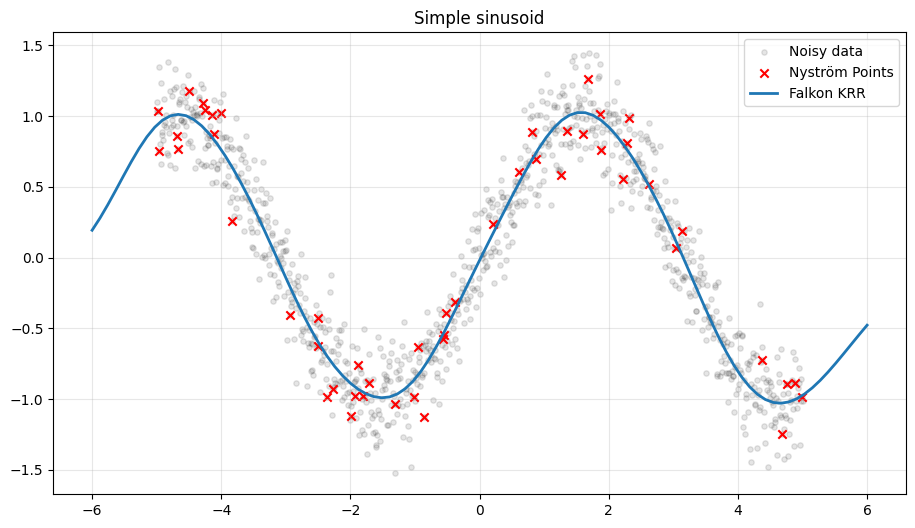

In [43]:
# Plot points
fig, ax = plt.subplots(1, 1, figsize=(11, 6))

ax.scatter(X, y_sin, s=15, alpha=0.1, label="Noisy data", marker="o",color="black")
ax.scatter(X[falkon.indices], y_sin[falkon.indices], label="Nyström Points",marker="x",color="red")
ax.plot(X_test, y_pred, lw=2, label="Falkon KRR")
ax.set_title("Simple sinusoid")
ax.legend(loc="best")
ax.grid(alpha=0.3)

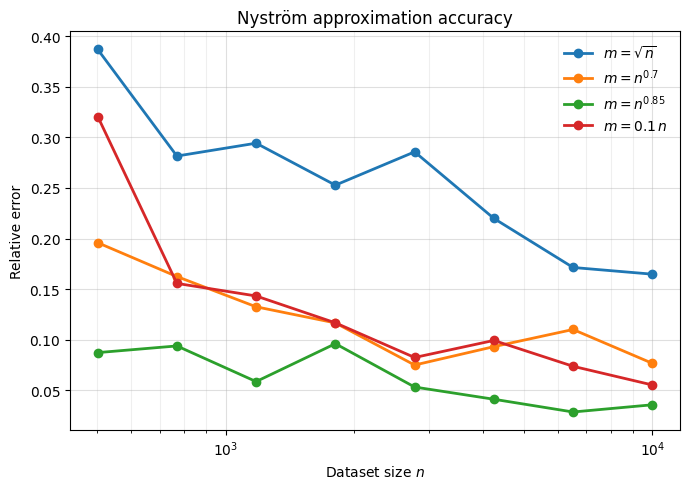

In [44]:
df = pd.read_csv("outputs/nystrom_error_scaling.csv")

# Ensure sorted order
n_values = np.sort(df["n"].unique())

m_values = {
    label: (
        df[df["scaling"] == label]
        .sort_values("n")["m"]
        .to_numpy()
        .astype(int)
    )
    for label in df["scaling"].unique()
}

errors = {
    label: (
        df[df["scaling"] == label]
        .sort_values("n")["rel_fro_error"]
        .to_numpy()
    )
    for label in df["scaling"].unique()
}

fig, ax = plt.subplots(figsize=(7, 5))

for label in m_values:
    ax.semilogx(
        n_values,
        errors[label],
        marker="o",
        linewidth=2,
        markersize=6,
        label=rf"$m={label}$",
    )

ax.set_xlabel(r"Dataset size $n$")
ax.set_ylabel(r"Relative error")
ax.grid(True, which="major", alpha=0.4)
ax.grid(True, which="minor", alpha=0.2)

ax.set_title(r"Nyström approximation accuracy")

ax.legend(frameon=False)

plt.tight_layout()
plt.savefig("figures/approximation.png", dpi=250)

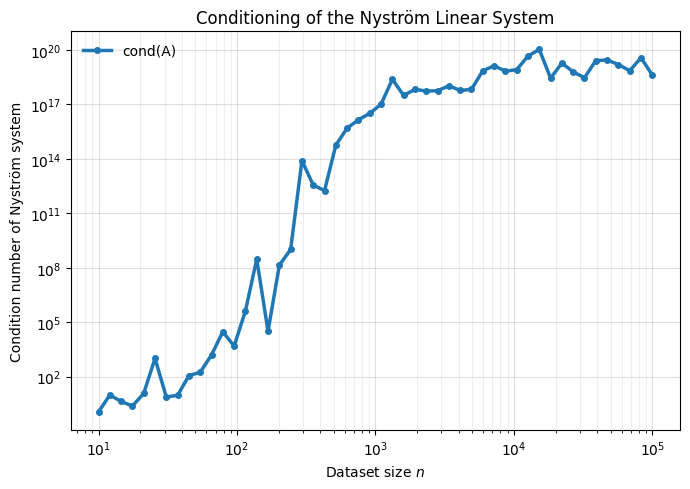

In [45]:
n_s, cond = pd.read_csv("outputs/condition_benchmark.csv")[["n", "condition_number"]].to_numpy().T
fig, ax = plt.subplots(figsize=(7, 5))

ax.loglog(
    n_s,
    cond,
    linewidth=2.5,
    color="#1f77b4",  # deep blue
    marker="o",
    markersize=4,
    label="cond(A)",
)

ax.set_xlabel(r"Dataset size $n$")
ax.set_ylabel(r"Condition number of Nyström system")
ax.set_title("Conditioning of the Nyström Linear System")

ax.grid(True, which="major", alpha=0.4)
ax.grid(True, which="minor", alpha=0.2)

ax.legend(frameon=False)

plt.tight_layout()
plt.savefig("figures/conditioning.png", dpi=250)


# Reproduction of Theoretical Results and Algorithms

In [46]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("outputs/bench_all_methods.csv")
df.head()

,method,n,m,time_sec
0,Vanilla,100,NaN,0.001833
1,Vanilla,151,NaN,0.002405
2,Vanilla,231,NaN,0.007776
3,Vanilla,351,NaN,0.015811
4,Vanilla,533,NaN,0.038736


In [47]:
def estimate_scaling_after_cutoff(df, n_min=1e3):
    results = {}

    for method, g in df.groupby("method"):
        # Apply cutoff
        g = g[g["n"] >= n_min]
        n = g["n"].to_numpy()
        t = g["time_sec"].to_numpy()
        alpha, logC = np.polyfit(np.log(n), np.log(t), 1)

        results[method] = {
            "alpha": alpha,
            "C": np.exp(logC),
            "n_min": n_min,
            "num_points": len(g)
        }
        print(
            f"{method:8s} | slope = {alpha:.3f} "
            f"(fit on {len(g)} pts, n >= {int(n_min)})"
        )

    return results


In [48]:
results = estimate_scaling_after_cutoff(df, n_min=1e3)

Falkon   | slope = 1.425 (fit on 14 pts, n >= 1000)
Nystrom  | slope = 1.430 (fit on 14 pts, n >= 1000)
Vanilla  | slope = 2.931 (fit on 6 pts, n >= 1000)


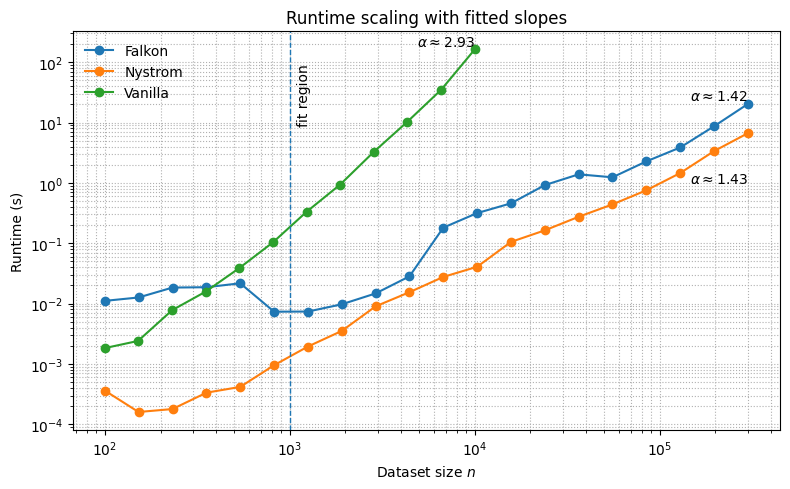

In [49]:
plt.figure(figsize=(8,5))

# Plot data
for method, g in df.groupby("method"):
    g = g.sort_values("n")
    plt.loglog(g["n"], g["time_sec"], "o-", label=method)

    # --- annotate slope ---
    if method in results:
        alpha = results[method]["alpha"]

        # choose rightmost point to place annotation
        n_annot = g["n"].iloc[-1]
        t_annot = g["time_sec"].iloc[-1]

        if method=="Nystrom":
             plt.text(
            n_annot,
            t_annot * 0.15,
            rf"$\alpha \approx {alpha:.2f}$",
            fontsize=10,
            ha="right",
             )
        else:
            plt.text(
                n_annot,
                t_annot * 1.15,
                rf"$\alpha \approx {alpha:.2f}$",
                fontsize=10,
                ha="right",
            )

# cutoff marker
plt.axvline(1e3, linestyle="--", linewidth=1)
plt.text(1.1e3, 1e1, r"fit region", rotation=90)

# cosmetics
plt.xlabel("Dataset size $n$")
plt.ylabel("Runtime (s)")
plt.title("Runtime scaling with fitted slopes")
plt.grid(True, which="both", linestyle=":")
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig("figures/scale_laxws.png", dpi=250)
